In [81]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten ,InputLayer, BatchNormalization,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.regularizers import L2
import wandb
from wandb.integration.keras import WandbMetricsLogger

# Wandb install

In [64]:
!pip install wandb
!wandb login

wandb: Currently logged in as: deeproyrs (deeproyrs-indian-institute-of-technology-madras). Use `wandb login --relogin` to force relogin


In [65]:
import wandb
from wandb.integration.keras import WandbMetricsLogger,WandbEvalCallback
wandb.init(project='CatsVsDogs',entity='deeproyrs-indian-institute-of-technology-madras')

In [66]:
wandb.run

In [67]:
wandb.config ={
    "LEARNING_RATE":0.001,
    "N_EPOCHS":5,
    "BATCH_SIZE":32,
    "DROPOUT_RATE": 0.0,
    "IM_SIZE": 224,
    "REGULARIZATION_RATE":0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE":3,
    "N_STRIDES":1,
    "POOL_SIZE":2,
    "N_DENSE_1":128,
    "N_DENSE_2":32,
}

In [68]:
dataset, dataset_info = tfds.load("cats_vs_dogs", with_info=True,as_supervised =True, shuffle_files=True , split = "train")

In [69]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [70]:
dataset_info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, 

# PreProcessing

In [71]:
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2

train_dataset = dataset.take(int(TRAIN_RATIO*len(dataset)))
val_dataset = dataset.skip(int(TRAIN_RATIO*len(dataset))).take(int(VAL_RATIO*len(dataset)))
test_dataset = dataset.skip(int((TRAIN_RATIO+VAL_RATIO)*len(dataset)))
print(train_dataset)

def print_dataset_shape(dataset):
    for element in dataset.take(1):  # Take one batch
        print(f"Shape of element: {element[0].shape}")  # Assuming the first element is the input; adjust if necessary
        break
# print("Training Dataset Shape:")
# print_dataset_shape(train_dataset)

# print("Validation Dataset Shape:")
# print_dataset_shape(val_dataset)

# print("Test Dataset Shape:")
# print_dataset_shape(test_dataset)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


# Data Visualization

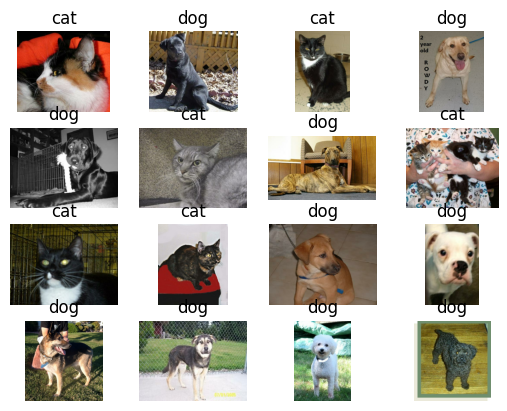

In [72]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(dataset_info.features["label"].int2str(label))
    plt.axis("off")

# Data Processing

In [73]:
CONFIGURATION = wandb.config
IM_SIZE = CONFIGURATION['IM_SIZE']
def resizing_rescale(image, label):
    image = tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0,label
    return image, label

In [74]:
train_dataset = train_dataset.map(resizing_rescale)
val_dataset = val_dataset.map(resizing_rescale)
test_dataset = test_dataset.map(resizing_rescale)

In [75]:
BATCH_SIZE = CONFIGURATION['BATCH_SIZE']
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [76]:
train_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# CNN Model

In [77]:
# Config values
N_EPOCHS = CONFIGURATION['N_EPOCHS']
DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
IM_SIZE = CONFIGURATION['IM_SIZE']
N_FILTERS = CONFIGURATION['N_FILTERS']
KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
N_STRIDES = CONFIGURATION['N_STRIDES']
POOL_SIZE = CONFIGURATION['POOL_SIZE']
N_DENSE_1 = CONFIGURATION['N_DENSE_1']
N_DENSE_2 = CONFIGURATION['N_DENSE_2']

# Model definition
model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

    # First Conv Layer
    tf.keras.layers.Conv2D(
        filters=N_FILTERS,
        kernel_size=KERNEL_SIZE,
        strides=(N_STRIDES, N_STRIDES),
        padding='valid',
        activation="relu",
        kernel_regularizer=L2(REGULARIZATION_RATE)
    ),
    BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=POOL_SIZE, strides=N_STRIDES*2),
    Dropout(rate=DROPOUT_RATE),
    # Second Conv Layer
    tf.keras.layers.Conv2D(
        filters=N_FILTERS*2 + 4,
        kernel_size=KERNEL_SIZE,
        strides=N_STRIDES,
        padding='valid',
        activation="relu",
        kernel_regularizer=L2(REGULARIZATION_RATE)
    ),
    BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=POOL_SIZE, strides=N_STRIDES*2),

    # Flatten and Dense layers
    Flatten(),
    Dense(N_DENSE_1, activation="relu", kernel_regularizer=L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    Dense(N_DENSE_2, activation="relu", kernel_regularizer=L2(REGULARIZATION_RATE)),
    BatchNormalization(),

    # Output layer
    Dense(1, activation="sigmoid")
])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │       5,972,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,978,033 (22.80 MB)

 Trainable params: 5,977,669 (22.80 MB)

 Non-trainable params: 364 (1.42 KB)

# Trainning CNN

In [78]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=BinaryCrossentropy(),
              metrics=[BinaryAccuracy()])

In [82]:
history  = model.fit(train_dataset,validation_data=val_dataset, epochs =5, verbose = 1, callbacks=[WandbMetricsLogger()])

Epoch 1/5
437/437 ━━━━━━━━━━━━━━━━━━━━ 55s 125ms/step - binary_accuracy: 0.6410 - loss: 0.6385 - val_binary_accuracy: 0.6627 - val_loss: 0.6103
Epoch 2/5
437/437 ━━━━━━━━━━━━━━━━━━━━ 75s 110ms/step - binary_accuracy: 0.7708 - loss: 0.4825 - val_binary_accuracy: 0.6234 - val_loss: 0.8104
Epoch 3/5
437/437 ━━━━━━━━━━━━━━━━━━━━ 81s 109ms/step - binary_accuracy: 0.8545 - loss: 0.3299 - val_binary_accuracy: 0.7393 - val_loss: 0.6301
Epoch 4/5
437/437 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - binary_accuracy: 0.9308 - loss: 0.1825 - val_binary_accuracy: 0.7231 - val_loss: 0.7325
Epoch 5/5
437/437 ━━━━━━━━━━━━━━━━━━━━ 80s 108ms/step - binary_accuracy: 0.9584 - loss: 0.1090 - val_binary_accuracy: 0.7418 - val_loss: 0.7742


# Evaluation

In [83]:
test_dataset = test_dataset.batch(1)

In [84]:
train_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [85]:
model.evaluate(test_dataset)

4653/4653 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - binary_accuracy: 0.7478 - loss: 0.7458


[0.7595216035842896, 0.7448957562446594]

In [86]:
model.predict(test_dataset.take(1))[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step


0.11391803